# Test short-term investment strategies

Here we'll define some metrics to select stocks for short-term investment and then generate the resulting income that we could have attained as a function of duration of investment and dollar amounts.

In [1]:
import utility_funcs as utf               # plotting and currency conversion functions
import sp500_data as sp5                  # functions to get sp500 market data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from yahoo_fin import stock_info as si    # functions to read in ticker time series
import datetime as dt
import pickle, os
from scipy import stats
%matplotlib inline

## first get S&P 500 market data

In [2]:
start_date = dt.datetime(2018,1,1)

d = dt.datetime.now()
todays_date = dt.datetime(d.year, d.month, d.day)
#end_date = todays_date
end_date = dt.datetime(2019,4,30)

In [3]:
sp500_dict = sp5.get_sp500_timeseries(start_date, end_date, retrieve_new_data=False)    # get time series data from the web
sp500_dict = sp5.compute_fractional_growth(sp500_dict)         # compute the fractional growth of each ticker
sp500_dict = sp5.compute_sp500_fractional_growth(sp500_dict)   # ad hoc calculation of fractional growth of the S&P

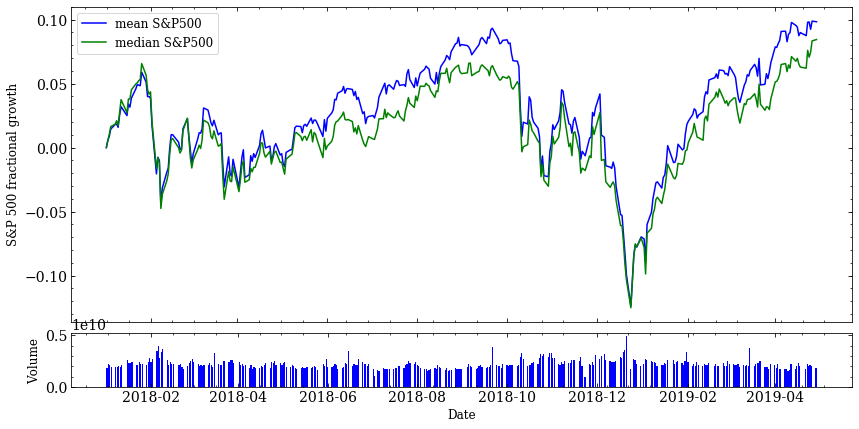

In [4]:
utf.plot_timeseries_SP500(sp500_dict)

## define some metric to identify promising stocks

In [5]:
# this metric compares the slope of a stock's fractional growth over a a given date range to the same slope for 
# the S&P 500. Let's see if stocks with larger slopes continue to perform in the proceeding months over which money
# would be invested

compute_slope = lambda x,y: (y[-1]-y[0]) / (x[-1]-x[0]) 


def compare_ticker_slope(ticker_dict, start_date, end_date, pltt=True):
    '''Compare the slope of a ticker over a date range to the SP500.'''
    # compute sp500 slope over that date range
    inrange = (sp500_dict['AAPL'].index >= start_date.date()) & (sp500_dict['AAPL'].index <= end_date.date())
    xarr, yarr = sp500_dict['delta_t_days'][inrange], sp500_dict['sp500_frac_growth_mean'][inrange]
    sp500_slope = compute_slope(xarr, yarr)
    
    # compute ticker slope
    ticker = list(ticker_dict.keys())[0]
    tarr = ticker_dict[ticker].index.map(mdates.date2num)
    xarr, yarr = tarr - tarr.min(), ticker_dict[ticker]['frac_growth']
    ticker_slope = compute_slope(xarr, yarr)
    
    # plot time series
    if pltt:
        utf.plot_timeseries_SP500(sp500_dict, ticker_dict)
        plt.show()
    
    # define metric
    slope_ratio = ticker_slope / sp500_slope
    
    return sp500_slope, ticker_slope, slope_ratio

In [6]:
# this metric compares the fractional growth of a stock over a given date range to the fractional growth of the S&P
# 500. Let's see if stocks with larger grwoth continue to perform in the proceeding months over which money
# would be invested

def compare_ticker_growth(ticker_dict, start_date, end_date, pltt=True):
    '''Compare the fractional growth of a ticker over a date range to the SP500.'''
    # compute sp500 slope over that date range
    inrange = (sp500_dict['AAPL'].index >= start_date.date()) & (sp500_dict['AAPL'].index <= end_date.date())
    xarr, yarr = sp500_dict['delta_t_days'][inrange], sp500_dict['sp500_frac_growth_mean'][inrange]
    sp500_frac_growth = sp500_dict['sp500_frac_growth_mean'][inrange][-1]
    
    # compute ticker slope
    ticker = list(ticker_dict.keys())[0]
    tarr = ticker_dict[ticker].index.map(mdates.date2num)
    xarr, yarr = tarr - tarr.min(), ticker_dict[ticker]['frac_growth']
    ticker_frac_growth = yarr[-1]
    
    # plot time series
    if pltt:
        utf.plot_timeseries_SP500(sp500_dict, ticker_dict)
        plt.show()
    
    # define metric
    growth_ratio = ticker_frac_growth / sp500_frac_growth
    
    return sp500_frac_growth, ticker_frac_growth, growth_ratio

In [13]:
# this metric compares the time derivative of the fractional growth of a stock over a given date range and identifies 
# the fractional of days for which the growth (i.e. the derivative) is positive in hoping that it will remain positive
# in the near future after money has been invested.


def compute_derivative_metric(ticker_dict):
    '''Get the derivative of a ticker's fractional growth and search for periods of sustained growth.'''
    
    # ensure that the time difference is mostly 1 day 
    # (3 or 4 day differences happen over weekends and on long weekends )
    ticker = list(ticker_dict.keys())[0]
    assert stats.mode(np.diff(ticker_dict[ticker].index.map(mdates.date2num))).mode[0] == 1
    
    # compute fractional growth derivative
    # treat gaps in coverage (e.g. weekends) as non-existent such that the fractional growth is continuous 
    # with a fixed time difference of 1 day
    ticker_dict[ticker]['frac_growth_derivative'] = np.gradient(ticker_dict[ticker]['frac_growth'], 1)
    
    # define metric: fraction of days experiencing growth
    growing = ticker_dict[ticker]['frac_growth_derivative'] > 0
    growth_freq = growing.sum() / float(growing.size)
    
    return ticker_dict, growth_freq

## define function to compute how much we gain 

In [14]:
def calculate_gain_fixed_sell(ticker, amount_to_invest_CAD, buy_date, sell_date, ticker_in_USD=True,
                              transaction_fee_CAD=9.99):
    '''Consider a hypothetical situation in which a certain amount of a stock is purchased on a certain date in the 
    past. What would the return on investment have been after some amount of time?'''
    # convert from USD to CAD?
    convert = utf.USD2CAD(1) if ticker_in_USD else 1.
    
    # calculate cost of purchase
    try:
        df = si.get_data(ticker, start_date=buy_date, end_date=sell_date)
    except UnicodeDecodeError:
        return np.repeat(np.nan, 5)
    
    buy_price_per_share_CAD = df['open'][0]*convert
    Nshares_to_buy = int(np.floor((amount_to_invest_CAD - transaction_fee_CAD) / buy_price_per_share_CAD))
    buy_price_total_CAD = Nshares_to_buy * buy_price_per_share_CAD + transaction_fee_CAD
    assert buy_price_total_CAD <= amount_to_invest_CAD
    
    # get return
    sell_price_per_share_CAD = df['open'][-1]*convert
    return_total_CAD = Nshares_to_buy * sell_price_per_share_CAD - transaction_fee_CAD
    gain = return_total_CAD - buy_price_total_CAD
    
    return buy_price_per_share_CAD, buy_price_total_CAD, sell_price_per_share_CAD, return_total_CAD, gain

## run the simulation on some stocks of interest

Let's consider a list of stocks that we are interested in and let's see how well we perform if we select stocks based on this metric, invest some funds, and then sell after a fixed amount of time. 

In [23]:
# define potential stocks of interest
#tickers = ['AC.TO','CTC.TO','BBD-B.TO','ACHC','RCI-B.TO']
tickers = utf.get_tickers(sp500_dict)
inds = np.arange(len(tickers))
np.random.shuffle(inds)
tickers = tickers[inds][:100]
#tickers = si.get_day_gainers()
Ntick = len(tickers)

In [24]:
# compute slope metrics and resulting growth
sp500_slopes, ticker_slopes, slope_ratios = np.zeros(Ntick), np.zeros(Ntick), np.zeros(Ntick)
sp500_frac_growths, ticker_frac_growths, growth_ratios = np.zeros(Ntick), np.zeros(Ntick), np.zeros(Ntick)
growth_freq = np.zeros(Ntick)
gain_CAD = np.zeros(Ntick)

start_date = dt.datetime(2018,9,1)
date_of_buy = dt.datetime(2019,1,1)
amount_to_invest_CAD = 1e3

for i in range(Ntick):
    
    print('%.3d\t%s'%(i+1,tickers[i]))

    # compute metrics for comparison to the gains
    try:
        ticker_dict = {tickers[i] : si.get_data(tickers[i], start_date=start_date, end_date=date_of_buy)}    
        ticker_dict = sp5.compute_fractional_growth(ticker_dict)
    except KeyError:
        pass
    
    # compute metrics
    p = compare_ticker_slope(ticker_dict, start_date, date_of_buy, pltt=False)
    sp500_slopes[i], ticker_slopes[i], slope_ratios[i] = p
    
    p = compare_ticker_growth(ticker_dict, start_date, date_of_buy, pltt=False)
    sp500_frac_growths[i], ticker_frac_growths[i], growth_ratios[i] = p
    
    p = compute_derivative_metric(ticker_dict)
    ticker_dict, growth_freq[i] = p

    # compute the gains if bought and sold at fixed dates
    p = calculate_gain_fixed_sell(tickers[i], amount_to_invest_CAD, date_of_buy, todays_date, ticker_in_USD=True)
    gain_CAD[i] = p[-1]

001	AME
002	FLS
003	CINF
004	FRC
005	FCX
006	SPGI
007	ROP
008	COF
009	ADM
010	WCG
011	APTV
012	TAP
013	LLL
014	PSA
015	CTAS
016	EW
017	PEP
018	PWR
019	FB
020	RL
021	DHI
022	DISH
023	CSX
024	RHT
025	CAG
026	MOS
027	AKAM
028	KSU
029	GLW
030	UNP
031	IT
032	LEG
033	AVGO
034	LUV
035	MMC
036	AFL
037	UNM
038	FAST
039	TTWO
040	RF
041	JWN
042	PNW
043	BR
044	STZ
045	TXT
046	STI
047	GPC
048	SNA
049	AEP
050	JKHY
051	EXPD
052	HFC
053	AVY
054	AAPL
055	PCAR
056	IPGP
057	MHK
058	CMCSA
059	CCL
060	WYNN
061	SPG
062	GIS
063	SYMC
064	CME
065	EVRG
066	DFS
067	ZBH
068	OMC
069	VIAB
070	NLSN
071	CF
072	CHTR
073	UNH
074	KEY
075	ALK
076	TIF
077	SWK
078	MDT
079	INTU
080	SEE
081	PGR
082	PKG
083	BMY
084	GOOG
085	GPS
086	SLB
087	RTN
088	CHD
089	MCHP
090	ITW
091	NFLX
092	NTRS
093	MTB
094	FDX
095	BHGE
096	ADBE
097	ICE
098	EXR
099	LW
100	AIG


169.49117032277172


((0.3, 0.65), (-200, 500))

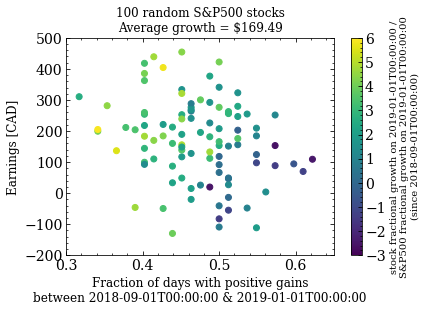

In [60]:
g = (growth_freq < .6) & (growth_ratios > 2)
g = np.repeat(True, Ntick)

avg_gain = gain_CAD[g].sum()/g.sum()
print(avg_gain)

# define fixed limits for visual comparisons
vmin, vmax = -3, 6
xlim, ylim = (.3,.65), (-200,500)

plt.figure(figsize=(6,4))
plt.scatter(growth_freq[g], gain_CAD[g], c=growth_ratios[g], vmin=vmin, vmax=vmax)
plt.plot(growth_freq[np.invert(g)], gain_CAD[np.invert(g)], 'k.', alpha=.2)
plt.colorbar(label='stock fractional growth on %s /\nS&P500 fractional growth on %s\n(since %s)'%(date_of_buy.isoformat(),
                                                                                                date_of_buy.isoformat(),
                                                                                                start_date.isoformat()))
plt.xlabel('Fraction of days with positive gains\nbetween %s & %s'%(start_date.isoformat(),date_of_buy.isoformat()), 
           fontsize=12)
plt.ylabel('Earnings [CAD]', fontsize=12)
plt.title('%i random S&P500 stocks\nAverage growth = $%.2f'%(g.sum(),avg_gain), fontsize=12)
plt.xlim(xlim), plt.ylim(ylim)

#plt.savefig()

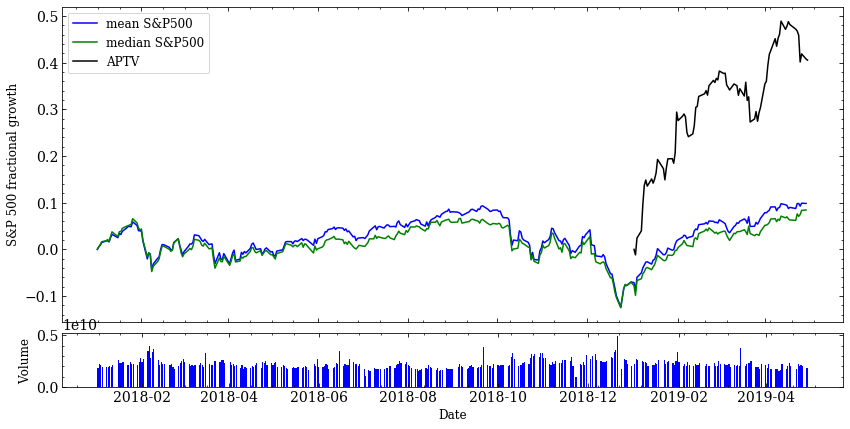

(60.349998474121094,
 975.5899755859375,
 85.48999786376953,
 1357.8499658203125,
 382.259990234375)

In [32]:
# test
ticker = 'APTV'
ticker_dict = {ticker:si.get_data(ticker, start_date=date_of_buy, end_date=todays_date)}
ticker_dict = sp5.compute_fractional_growth(ticker_dict)
utf.plot_timeseries_SP500(sp500_dict, ticker_dict)
calculate_gain_fixed_sell(ticker, 1e3, date_of_buy, todays_date, ticker_in_USD=False)